In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [63]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50
from skimage.transform import resize

import json

In [3]:
torch.cuda.set_device(0)

In [4]:
torch.backends.cudnn.benchmark=True

## Data

In [18]:
PATH = Path('data/tgs_salt/')
MASKS_FN = 'train.csv'
masks_csv = pd.read_csv(PATH/MASKS_FN)


In [19]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [20]:
TRAIN_DN = 'train/images/train-128'
MASKS_DN = 'train/images/train_masks-128'
sz = 128
bs = 64
nw = 16

In [21]:
TRAIN_DN = 'train/images'
MASKS_DN = 'train/masks'
sz = 128
bs = 64
nw = 16

In [22]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [23]:
x_names = np.array([Path(TRAIN_DN)/f'{o}.png' for o in masks_csv['id']])
y_names = np.array([Path(MASKS_DN)/f'{o}.png' for o in masks_csv['id']])

In [24]:
val_idxs = list(range(1008))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [25]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]

In [26]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [27]:
x,y = next(iter(md.trn_dl))

In [28]:
x.shape,y.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 128, 128]))

## Simple upsample

In [29]:
f = resnet34
cut,lr_cut = model_meta[f]

In [30]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [31]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [32]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [33]:
class Upsample34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.features = nn.Sequential(
            rn, nn.ReLU(),
            StdUpsample(512,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            nn.ConvTranspose2d(256, 1, 2, stride=2))
        
    def forward(self,x): return self.features(x)[:,0]

In [34]:
class UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model.features)[1:]]

In [35]:
m_base = get_base()

In [36]:
m = to_gpu(Upsample34(m_base))
models = UpsampleModel(m)

In [37]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [38]:
learn.freeze_to(1)

 89%|████████▉ | 42/47 [00:15<00:01,  2.68it/s, loss=1.54] 

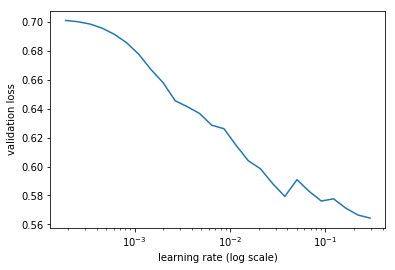

In [39]:
learn.lr_find()
learn.sched.plot()

In [40]:
lr=4e-2
wd=1e-7
lrs = np.array([lr/100,lr/10,lr])/2

In [41]:
learn.fit(lr,1, wds=wd, cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.332567   0.862286   0.821399   0.689069  
    1      0.259348   0.205741   0.917903   0.829867       
    2      0.227302   0.183807   0.927664   0.848061       
    3      0.197479   0.157817   0.933261   0.864228       


[0.15781695029092213, 0.9332605401674906, 0.8642280991115268]

In [42]:
learn.save('tmp')

In [43]:
learn.load('tmp')

In [44]:
learn.unfreeze()
learn.bn_freeze(True)

In [45]:
learn.fit(lrs,1,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.205509   0.237011   0.872738   0.730144  
    1      0.19312    0.16854    0.933169   0.858807       
    2      0.173791   0.166064   0.927492   0.860728       
    3      0.157831   0.145412   0.939756   0.880178       


[0.145411511971837, 0.9397564861509535, 0.8801778564377437]

In [46]:
learn.save('128')

In [47]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

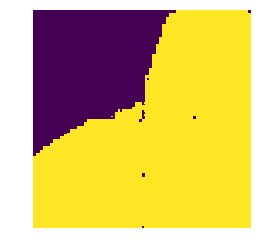

In [56]:
show_img(py[10]>0);

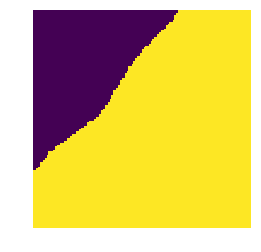

In [57]:
show_img(y[10]);

In [51]:
preds_test = learn.predict()

In [52]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [59]:
folder = "data/tgs_salt/test/images"
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
testfile_name = pd.DataFrame({'img':onlyfiles})
print(len(onlyfiles))

18000


In [60]:
testfile_name = pd.DataFrame({'img':onlyfiles})
testfile_name = pd.DataFrame(testfile_name.img.str.split('.',1).tolist(), columns = ['img','png'])

In [61]:
img_size_ori = 101
img_size_target = 128

def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

In [64]:
pred_dict = {idx: RLenc(np.round(downsample(preds_test[i]) > 0.5)) for i, idx in enumerate(tqdm_notebook(testfile_name["img"]))}

IndexError: index 1008 is out of bounds for axis 0 with size 1008

In [ ]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')